<a href="https://colab.research.google.com/github/TXH2020/MainRepo/blob/main/Academics/Image%20Processing/Attendance_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Very Important!!
##**1. Please set the runtime to GPU. To do this goto Runtime-->Change Runtime Type-->GPU. Also execute the last cell of this notebook without fail to preserve GPU for future sessions.**
##**2. At the beginning of the program, two requests will be presented to you to  access your drive for accessing the concerned spreadsheet(assuming it is in your google drive) and mounting the google drive respectively. Please approve them for the successful completion of the program.**

\


##Note: When you run the notebook for the first time, it may take a lot of time to execute. This is because the program retrieves images and extracts face encoding. However, the face encodings are then stored in drive so that the extraction process doesnt repeat and future sessions run quickly.

In [1]:
!pip install --upgrade -q gspread
!pip install face_recognition
!pip install --upgrade --no-cache-dir gdown

     |████████████████████████████████| 40 kB 639 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100.1 MB 26 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=9fd6cadf320bf52d8a5bf47c5f5e90b8e7cd0c84eb35aa8ee4e98717143baf57
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [2]:
import numpy as np
import gspread
import pandas as pd
from google.colab import auth
from google.colab import drive
from google.auth import default
import pickle
import os
import gdown

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
worksheet_name='Database Of Face Photos (Responses)'
worksheet = gc.open(worksheet_name).sheet1
rows = worksheet.get_all_values()
df=pd.DataFrame.from_records(rows,columns=rows[0],nrows=1)
df1=df.drop(0)
df1.reset_index
df1.set_index(np.arange(0,len(rows)-1),inplace=True)
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import face_recognition
from PIL import Image
# Load the jpg files into numpy arrays
def encoding(df,face_encoding):
  known_image=[0 for i in range(len(face_encoding)+df.shape[0])]
  for i in range(len(face_encoding),len(face_encoding)+df.shape[0]):
    print(df['NAME'][i]+".jpg")
    known_image[i]=face_recognition.load_image_file(df['NAME'][i]+".jpg")

# Get the face encodings for each face in each image file
# Since there could be more than one face in each image, it returns a list of encodings.
# But since I know each image only has one face, I only care about the first encoding in each image, so I grab index 0.
  for i in range(len(face_encoding),len(face_encoding)+df.shape[0]):
    try:
      print("Extracting face encoding for photo:",i)
      face_encoding.append(face_recognition.face_encodings(known_image[i],model='cnn')[0])
  #unknown_face_encoding = face_recognition.face_encodings(unknown_image,model='cnn')
    except IndexError:
      im1=Image.open(df['NAME'][i]+".jpg")
      im2=im1.copy().rotate(270)
      im2.save('check.jpg')
      error_image=face_recognition.load_image_file("check.jpg")
      try:
        face_encoding.append(face_recognition.face_encodings(error_image,model='cnn')[0])
      except:
        im1=Image.open('check.jpg')
        im2=im1.copy().rotate(180)
        im2.save('check1.jpg')
        error_image1=face_recognition.load_image_file("check1.jpg")
        face_encoding.append(face_recognition.face_encodings(error_image1,model='cnn')[0])
  store_data(face_encoding)

In [4]:
def download_photos(df,l1):
 for i in range(len(l1),len(l1)+df.shape[0]):
  print("Downloading photo:",i)
  a=df['Your Photo'][i]
  file_id=a[a.find('=')+1:]
  url="https://drive.google.com/uc?id={}".format(file_id)
  gdown.download(url, df['NAME'][i]+".jpg", quiet=True)
 encoding(df,l1)

In [5]:
def store_data(face_encoding):
  %cd drive/MyDrive
  with open(worksheet_name+'.pkl','wb') as p:
    pickle.dump(face_encoding,p)
  %cd /content

In [6]:
if(os.path.isfile('drive/MyDrive/'+worksheet_name+'.pkl')==False):
  download_photos(df1,[])

%cd drive/MyDrive
with open(worksheet_name+'.pkl','rb') as p:
    face_encoding=pickle.load(p)
%cd /content

#This code is optional. It was designed to deal with new responses.In case you need it, uncomment the code.
if(len(face_encoding)<df1.shape[0]):
  download_photos(df1.iloc[len(face_encoding):],face_encoding)

/content/drive/MyDrive
/content


In [7]:
ui=face_recognition.load_image_file('drive/MyDrive/group.jpg')
unknown_face_encoding=face_recognition.face_encodings(ui,model='cnn')

In [45]:
placea=[]
d={}
l1=[0 for i in range(len(face_encoding))]
def find_index(fe,i):
  if(len(fe)==0):
    return [i]
  result=face_recognition.face_distance(fe,unknown_face_encoding[i])
  val=min(result)
  if(val<0.48):
    place=list(result).index(val)
    return (place,val)
  return [i]

def mark(p,fe):
  if(type(p)==list):
    print("Not able to recognize unknown face ",p[0])
    placea.append(-1)
    return
  elif(l1[p[0]]!=1):
    l1[p[0]]=1
    d[p[0]]=[p[1],i]
    placea.append(p[0])
    return
  else:
    fem=fe.copy()
    if(d[p[0]][0]>p[1]):
      prev=d[p[0]][1]
      d[p[0]]=[p[1],i]
    else:
      prev=i
    fem.pop(p[0])
    o=find_index(fem,prev)
    mark(o,fem)

for i in range(len(unknown_face_encoding)):
  p=find_index(face_encoding,i)
  mark(p,face_encoding)

for i in range(len(l1)):
  if(l1[i]==1):
    print(df1['NAME'][i], " is Present")
  else:
    print(df1['NAME'][i], " is Absent")

Not able to recognize unknown face  1
Not able to recognize unknown face  9
Not able to recognize unknown face  11
Not able to recognize unknown face  14
Not able to recognize unknown face  15
Not able to recognize unknown face  16
ARNAV A RAJESH   is Present
Vinay B Sahani   is Absent
MADHUMITA   is Present
Swastik Puri  is Present
Tejas Hegde   is Present
Sanskar R Gondkar  is Absent
ARKODEEP KOLEY  is Present
Chakradhar  is Absent
ANKESH MOHAN NAIK   is Absent
Kushal R   is Absent
Ninaad P S  is Absent
GANESH SHEKHAR NAIK  is Present
SUBHAJJI SUHAS   is Absent
Shiya Singh  is Absent
SKANDA S KUMAR   is Present
Bharath M B  is Absent
Abhinav S  is Absent
Manas Kulshrestha  is Absent
SHAWN DANIEL RODRIGUES  is Absent
R Jayanth Jadhav  is Absent
Supreeth KG  is Present
Pratham Jain   is Absent
BHARGAVA M  is Absent
Snehal Vats  is Absent
Rohan Sriharsha  is Absent
Aman bhatnagar  is Absent
Amaan Adil   is Present
Aditya Anand   is Absent
Haarish Anandan  is Absent
Pratham M  is Present

###Below cell is optional. It shows how the attendance is actually taken and is useful to cross check the attendance. Uncomment the cell to run it.

found 17 face(s) in class photograph.


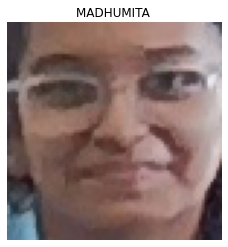

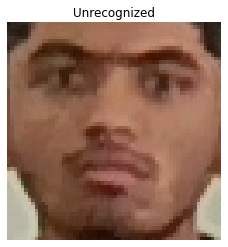

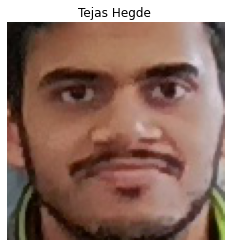

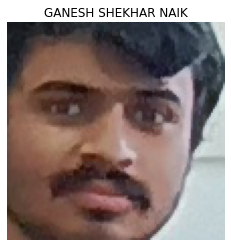

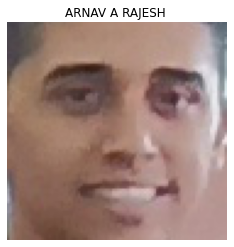

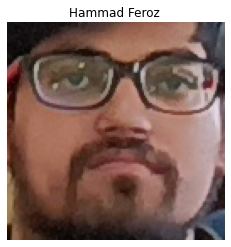

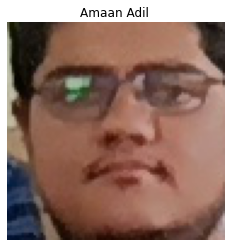

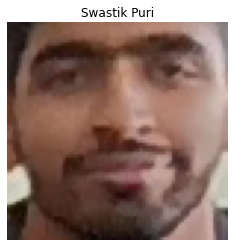

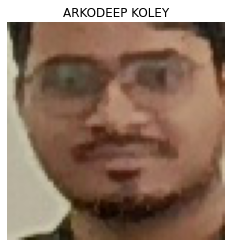

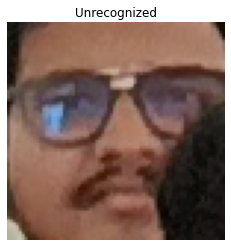

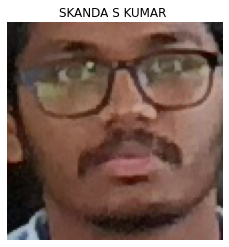

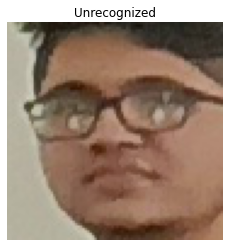

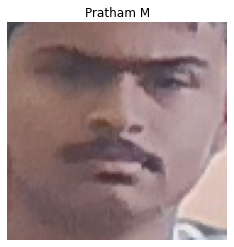

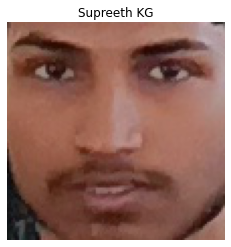

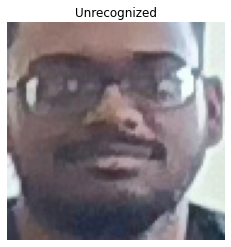

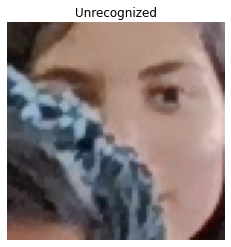

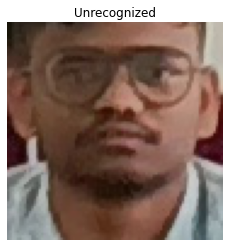

In [56]:
import matplotlib.pyplot as plt
face_locations = face_recognition.face_locations(ui)

print("found {} face(s) in class photograph.".format(len(face_locations)))
c=0
for face_location in face_locations:

    # Print the location of each face in this image
    top, right, bottom, left = face_location

    # You can access the actual face itself like this:
    face_image = ui[top:bottom, left:right]
    pil_image = Image.fromarray(face_image)
    if(placea[c]!=-1):
      plt.title(df1['NAME'][placea[c]])
    else:
      plt.title("Unrecognized")
    plt.imshow(pil_image)
    plt.axis('off')
    c+=1
    plt.show()

##**Please execute this cell to terminate session and preserve GPU.**

In [ ]:
from google.colab import runtime
runtime.unassign()